# Модель для предсказания массы морских черепах



Цели и задачи проекта:
  1. Ознакомиться с данными
  2. Проверить их корректность и провести предобработку
  3. Провести исследовательский анализ данных
  4. Обучить, протестировать и выбрать лучшую модель линейной регрессии

## Постановка задачи машинного обучения

- Необходимо решить задачу регрессии
- Целевой переменной явлется масса черепахи в килограммах. (weight)
- Основной метрикой качества явлется MAE, в качестве дополнительных метрик будут использоваться MSE, R², MAPE
- Критерием успешности проекта является значение MAE меньше 5 килограмм

## Подключение и настройка библиотек

В блоке кода ниже, помимо уже указанных библиотек, импортируйте все остальные, которые планируете использовать для проекта.

In [1]:
!pip install phik

     |████████████████████████████████| 677 kB 2.4 MB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
import warnings
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)
warnings.filterwarnings('ignore', 
    message='Maximum number of iteration reached')

## Загрузка датасета

- Загрузите данные из файла `turtles.csv`, путь к файлу: `'/datasets/turtles.csv'`. При использовании метода [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) установите правильные значения для параметров `sep` и `decimal`: в качестве разделителя столбцов используйте символ табуляции (`'\t'`), а в качестве разделителя дробной части — запятую.
- Проверьте, правильно ли прошла загрузка. Данные должны соответствовать описанию в тексте урока.
- С помощью методов библиотеки pandas выведите общие сведения о данных.
- Возможно ли продолжать работу? Если нет — что нужно сделать, чтобы устранить препятствия?

In [3]:
start_df = pd.read_csv('https://code.s3.yandex.net/datasets/turtles.csv', sep='\t', decimal=',')
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8861 entries, 0 to 8860
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   8861 non-null   int64  
 1   binomial_name        8812 non-null   object 
 2   registration number  8832 non-null   object 
 3   shell_length         8774 non-null   float64
 4   shell_width          8861 non-null   int64  
 5   head_length          8715 non-null   float64
 6   head_width           8715 non-null   float64
 7   flipper_length_1     8861 non-null   int64  
 8   flipper_width_1      8861 non-null   int64  
 9   flipper_length_2     8861 non-null   int64  
 10  flipper_width_2      8861 non-null   int64  
 11  flipper_length_3     8760 non-null   float64
 12  flipper_width_3      8760 non-null   float64
 13  flipper_length_4     8760 non-null   float64
 14  flipper_width_4      8760 non-null   float64
 15  circle_count         8861 non-null   i

In [4]:
# Приведенение столбца 'registration number' к snake_case
start_df = start_df.rename(columns={'registration number' : 'registration_number'})
# Приведение столбца 'binomial_name' к нижнему регистру
start_df['binomial_name'] = start_df['binomial_name'].str.lower()

for column in start_df.columns:
    print(f"Доля пустых значений в столбце {column}:{(1 - start_df[column].notna().sum() / start_df.shape[0]) * 100:.2f}%")

Доля пустых значений в столбце id:0.00%
Доля пустых значений в столбце binomial_name:0.55%
Доля пустых значений в столбце registration_number:0.33%
Доля пустых значений в столбце shell_length:0.98%
Доля пустых значений в столбце shell_width:0.00%
Доля пустых значений в столбце head_length:1.65%
Доля пустых значений в столбце head_width:1.65%
Доля пустых значений в столбце flipper_length_1:0.00%
Доля пустых значений в столбце flipper_width_1:0.00%
Доля пустых значений в столбце flipper_length_2:0.00%
Доля пустых значений в столбце flipper_width_2:0.00%
Доля пустых значений в столбце flipper_length_3:1.14%
Доля пустых значений в столбце flipper_width_3:1.14%
Доля пустых значений в столбце flipper_length_4:1.14%
Доля пустых значений в столбце flipper_width_4:1.14%
Доля пустых значений в столбце circle_count:0.00%
Доля пустых значений в столбце measure_count:2.98%
Доля пустых значений в столбце shell_crack:75.44%
Доля пустых значений в столбце timestamp:0.00%
Доля пустых значений в столбце

Выводы по выгруженным данным:
  - Датафрейм представлен 8861 строками и 20 столбцами в которых содержится информация относительно характеристик черепах разных видов
  - В 12 из 20 столбцов есть пропуски, наибольшее значение пропусков наблюдается в столбце shell_crack: 75.44% пропусков.

## Исследовательский анализ данных

Проведите исследовательский анализ данных:
1. Выясните, данные о каких черепахах представлены в датасете.
2. Проведите отбор записей о нужном виде черепах. Для дальнейшей работы достаточно изучить только *Chelonia mydas*. При этом вы можете сравнить распределение данных об этих черепахах с другими видами, если есть желание и время.
3. Определите, все ли признаки можно использовать для решения задачи. Ответ обоснуйте. Удалите признаки, которые вам никак не помогут.
4. Проверьте, есть ли в данных пропуски. Определите, какие из них можно обработать сразу, а в каких случаях лучше сперва провести разделение на выборки. Решите, стоит ли удалить некоторые пропуски.
5. Определите, есть ли в данных дубликаты. Выберите корректный способ их обработки.
6. Проанализируйте распределение признаков, постройте необходимые для этого визуализации: ящики с усами, гистограммы и так далее. Определите, есть ли в данных выбросы и какие из них критичные. Решите, можно ли их сразу исправить.
7. Проверьте, одинаков ли масштаб признаков. Если он различается, предложите решение этой проблемы.
8. Проанализируйте корреляцию между признаками и целевой переменной с помощью вычислений и графически. Определите, все ли признаки нужны для дальнейшей работы.
9. Проверьте данные на мультиколлинеарность и решите, можно ли её устранить.

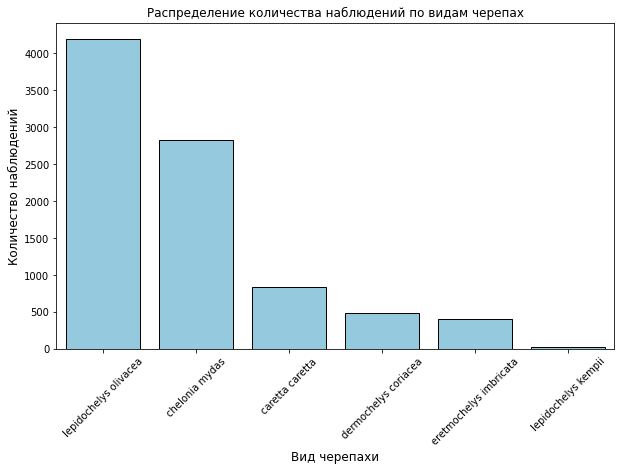

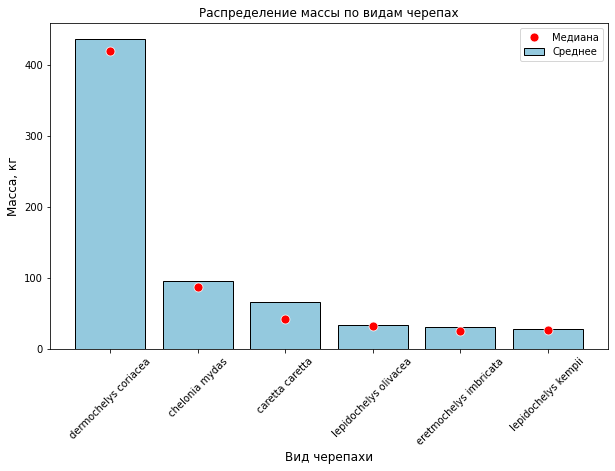

In [5]:
turtles_df = start_df.groupby('binomial_name')[['weight']].agg(['count', 'mean', 'median']).reset_index()
turtles_df = turtles_df.sort_values(('weight', 'count'), ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(data=turtles_df,
           x='binomial_name',
           y=('weight', 'count'),
           color='skyblue',
           edgecolor='black')

plt.title('Распределение количества наблюдений по видам черепах')
plt.xticks(rotation=45)
plt.xlabel('Вид черепахи', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.show()


plt.figure(figsize=(10, 6))
turtles_df = turtles_df.sort_values(('weight', 'mean'), ascending=False)
ax = sns.barplot(data=turtles_df,
                 x='binomial_name',
                 y=('weight', 'mean'),
                 color='skyblue',
                 edgecolor='black',
                 label='Среднее')

sns.scatterplot(data=turtles_df,
               x='binomial_name',
               y=('weight', 'median'),
               color='red',
               s=80,
               marker='o',
               label='Медиана',
               zorder=5)

plt.title('Распределение массы по видам черепах')
plt.xticks(rotation=45)
plt.xlabel('Вид черепахи', fontsize=12)
plt.ylabel('Масса, кг', fontsize=12)
plt.show()

Наибольшее количество наблюдений черепах (4201) сделано по виду 'lepidochelys olivacea' (47.8%). По интересующему нас виду 'chelonia mydas' сделано 2826 записей (32.1%).\
Медиана и среденее значение по всем видам, кроме 'caretta caretta' примерно одинаковы, но все-таки среднее всегда выше медианы. Это свидетельствует о существовании в данных выбросов с высокими значениями массы.

In [6]:
start_df['shell_crack'] = start_df['shell_crack'].apply(lambda x: 0 if pd.isna(x) else 1)

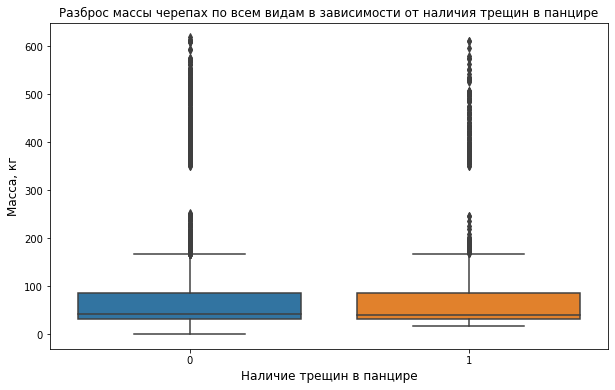

                  mean  median
shell_crack                   
0            78.889332  41.711
1            80.004485  39.511



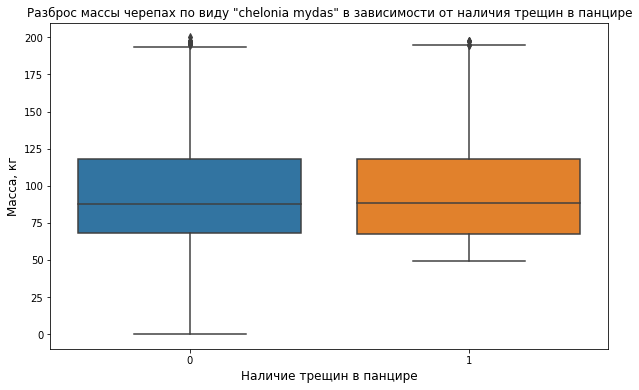

                  mean   median
shell_crack                    
0            96.311385  87.7285
1            96.936823  88.5415


In [7]:
# визуально проверяем влияют ли трещины на панцире на массу черепахи

# барплот по всем видам черепах
plt.figure(figsize=(10 ,6))
sns.boxplot(data=start_df, x='shell_crack', y='weight')

plt.title('Разброс массы черепах по всем видам в зависимости от наличия трещин в панцире')
plt.xlabel('Наличие трещин в панцире', fontsize=12)
plt.ylabel('Масса, кг', fontsize=12)
plt.show()
print(start_df.groupby('shell_crack')['weight'].agg(['mean', 'median']))
print()


# датасет с видом "chelonia mydas"
chelonia_mydas_df = start_df[start_df['binomial_name']=='chelonia mydas']

# Барплот по виду "chelonia mydas"
plt.figure(figsize=(10 ,6))
sns.boxplot(data=chelonia_mydas_df, x='shell_crack', y='weight')

plt.title('Разброс массы черепах по виду "chelonia mydas" в зависимости от наличия трещин в панцире')
plt.xlabel('Наличие трещин в панцире', fontsize=12)
plt.ylabel('Масса, кг', fontsize=12)
plt.show()

print(chelonia_mydas_df.groupby('shell_crack')['weight'].agg(['mean', 'median']))

In [8]:
corr_test = chelonia_mydas_df[['shell_crack', 'weight']]
print(f"Корреляция между shell_crack и weight: {corr_test.phik_matrix()['weight'][0]:.2f}")

interval columns not set, guessing: ['shell_crack', 'weight']
Корреляция между shell_crack и weight: 0.04


In [9]:
chelonia_mydas_df = chelonia_mydas_df.drop(columns=['id', 'binomial_name',
                                                    'registration_number',
                                                    'measure_count', 'timestamp',
                                                    'shell_crack'])
chelonia_mydas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2829 entries, 8 to 8859
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   shell_length      2794 non-null   float64
 1   shell_width       2829 non-null   int64  
 2   head_length       2790 non-null   float64
 3   head_width        2790 non-null   float64
 4   flipper_length_1  2829 non-null   int64  
 5   flipper_width_1   2829 non-null   int64  
 6   flipper_length_2  2829 non-null   int64  
 7   flipper_width_2   2829 non-null   int64  
 8   flipper_length_3  2798 non-null   float64
 9   flipper_width_3   2798 non-null   float64
 10  flipper_length_4  2798 non-null   float64
 11  flipper_width_4   2798 non-null   float64
 12  circle_count      2829 non-null   int64  
 13  weight            2826 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 396.1 KB


Удалили следующие столбцы:
  - id : не может оказывать никакого влияния на целевую переменную
  - binomial_name : не может оказывать никакого влияния на целевую переменную
  - registration_number : не может оказывать никакого влияния на целевую переменную
  - measure_count : не может оказывать никакого влияния на целевую переменную
  - timestamp : не может оказывать никакого влияния на целевую переменную
  - shell_crack : проверили визуально и посмотрели корреляцию, не оказывает какого-либо серьезного влияния

In [10]:
# улаляем строки с пропусками в целевой переменной

count_before = chelonia_mydas_df.shape[0]
print(f"Количество записей в начальном датафрейме: {count_before}")

chelonia_mydas_df = chelonia_mydas_df.dropna(subset=['weight'], axis=0)

count_after = chelonia_mydas_df.shape[0]
print(f"Количество записей после удаления строк с пропусками в weight: {count_after}")

print(f"Количество удаленных записей: {count_before - count_after}")
print(f"Доля удаленных записей: {(count_before - count_after) / count_before * 100 :.2f}%")

Количество записей в начальном датафрейме: 2829
Количество записей после удаления строк с пропусками в weight: 2826
Количество удаленных записей: 3
Доля удаленных записей: 0.11%


In [11]:
print(f"Количество полных дубликатов в датафрейме: {chelonia_mydas_df.duplicated().sum()}")

Количество полных дубликатов в датафрейме: 340


Несмотря на то, что полные совпадения в таких данных вполне возможны, вероятность таких совпадений крайне мала, поэтому повторные записи удаляем.

In [12]:
# Удаляем дубликаты
chelonia_mydas_df = chelonia_mydas_df.drop_duplicates(keep='first')

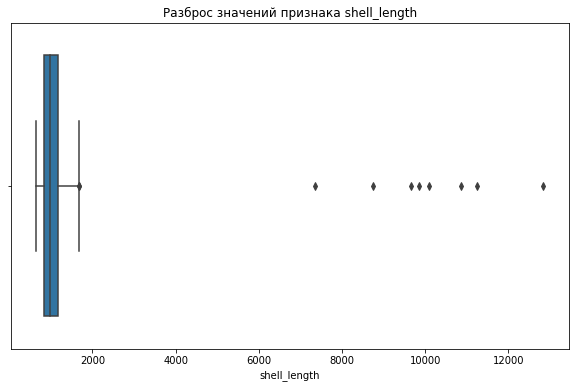

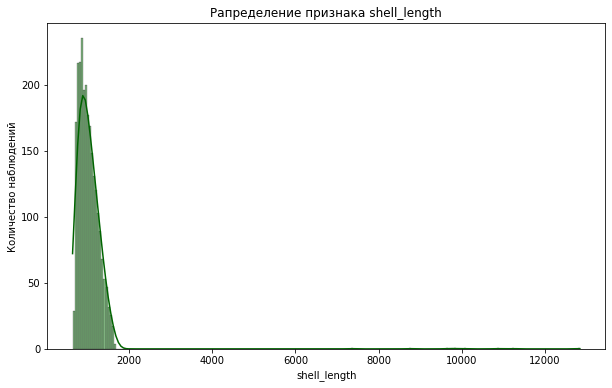

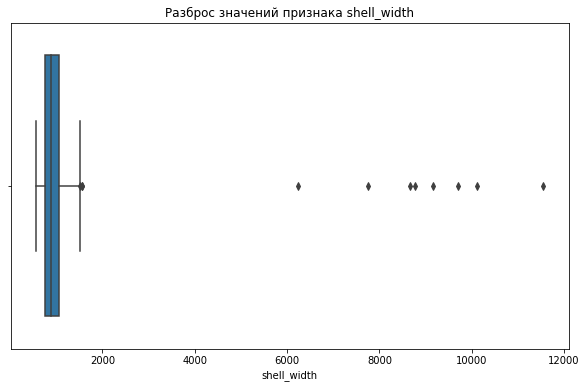

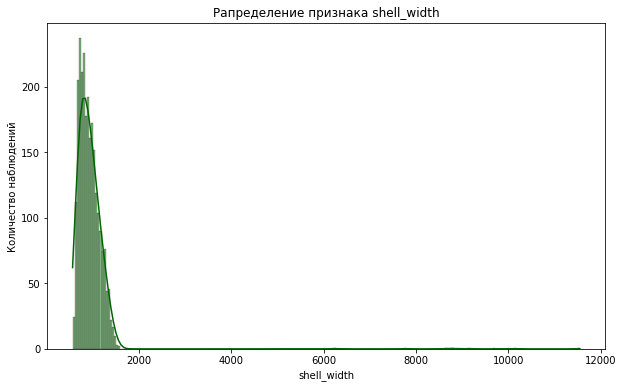

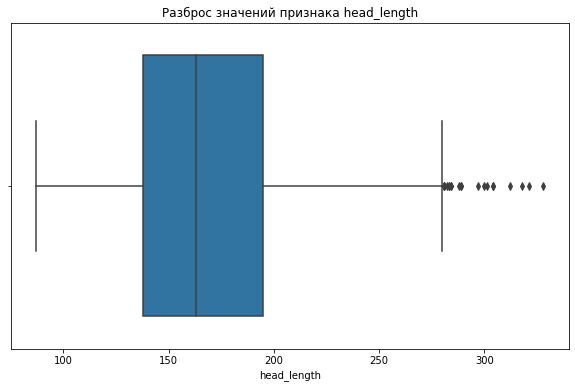

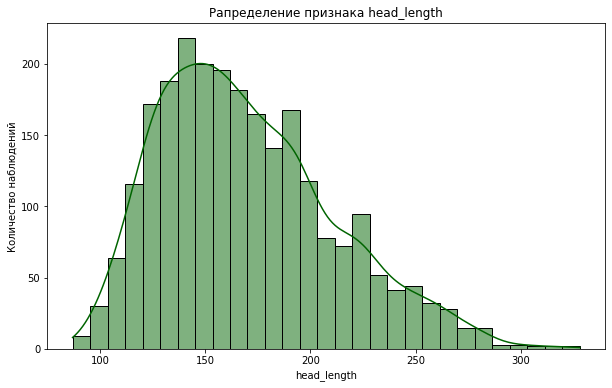

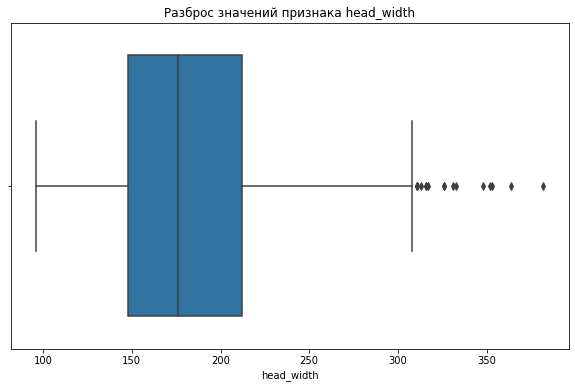

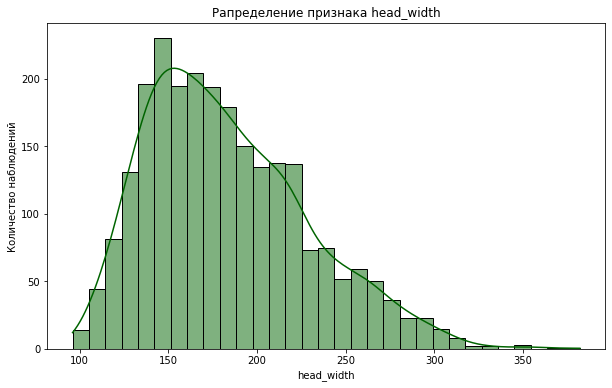

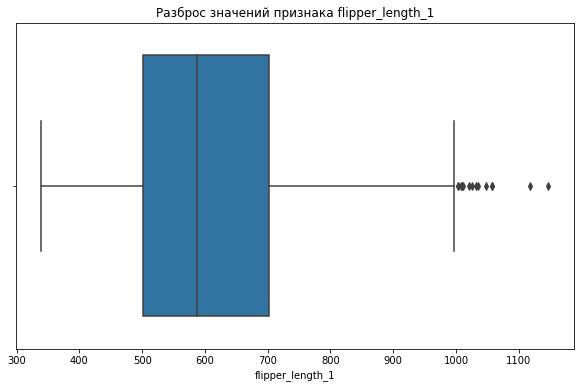

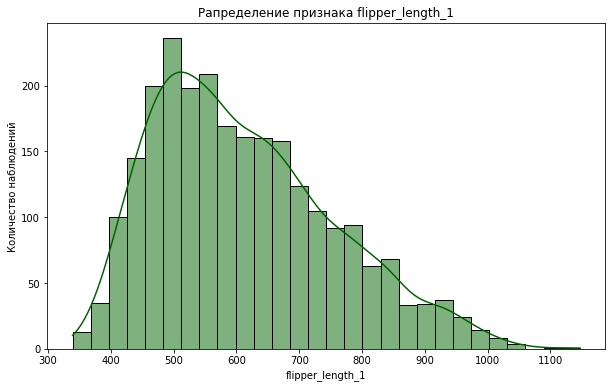

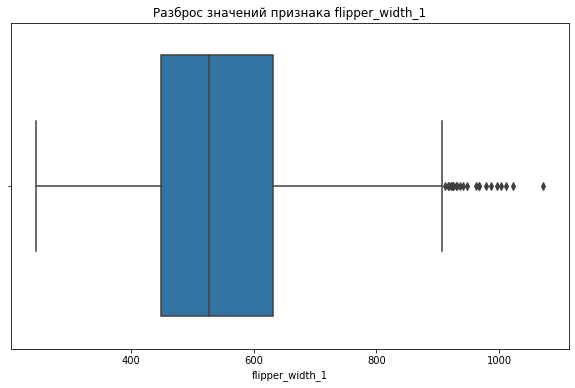

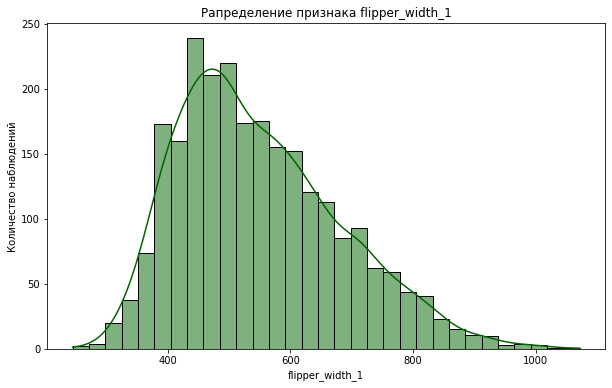

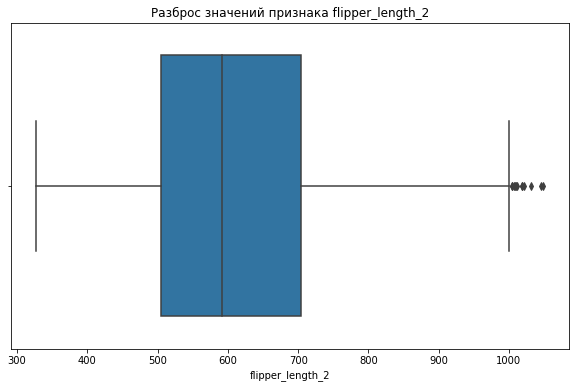

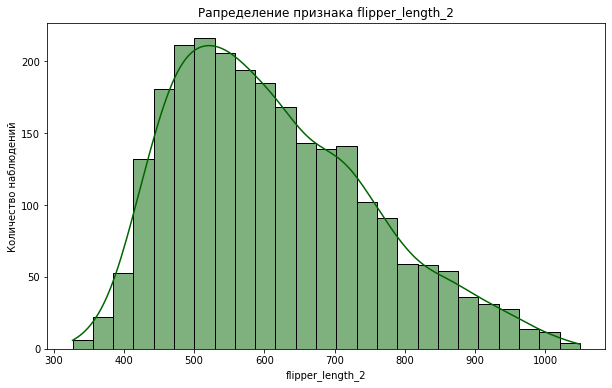

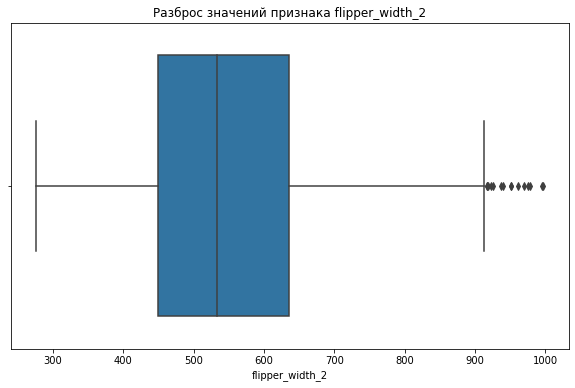

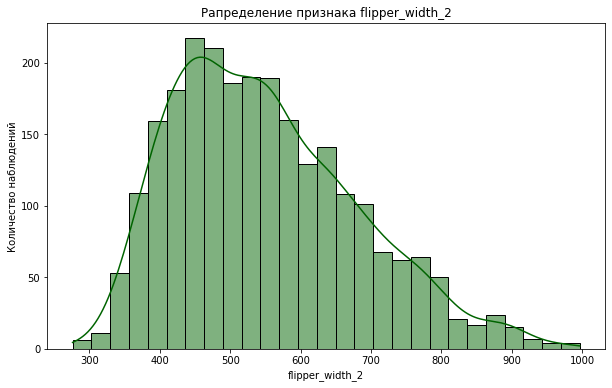

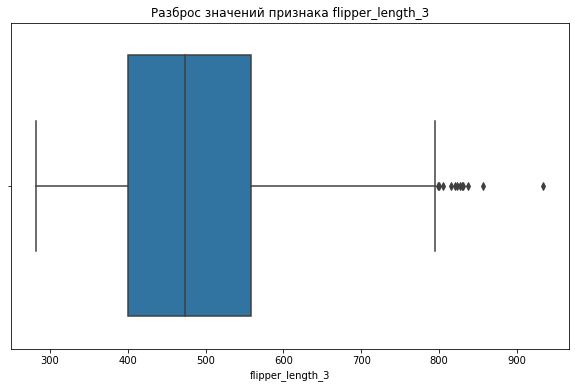

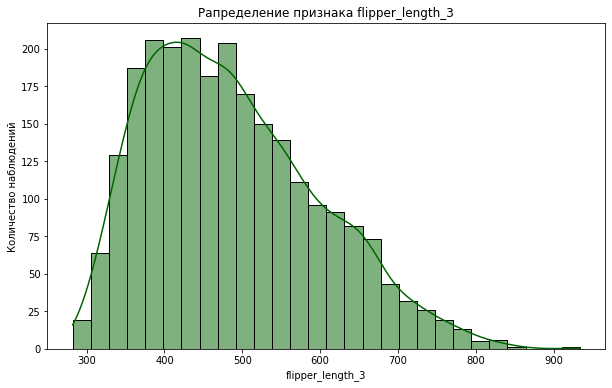

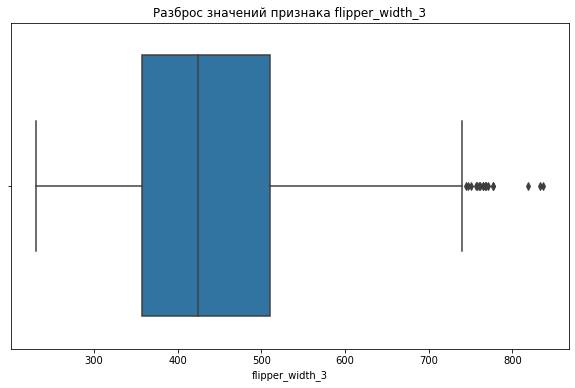

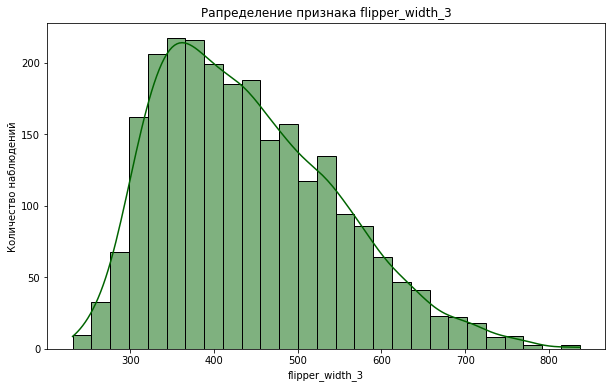

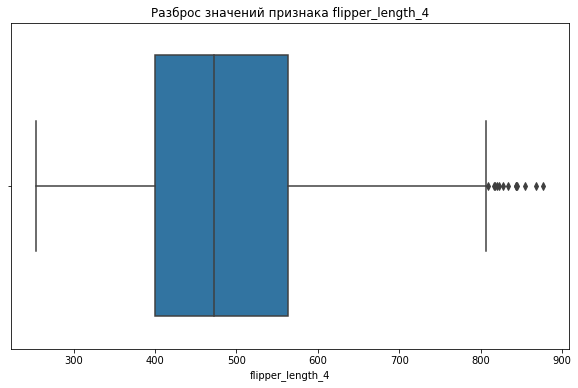

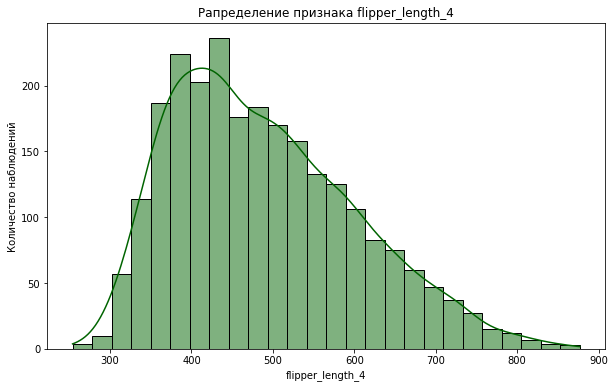

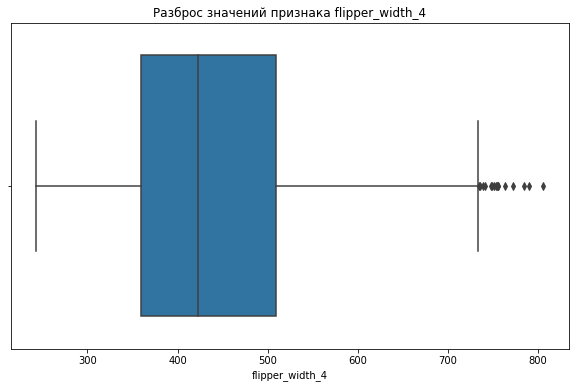

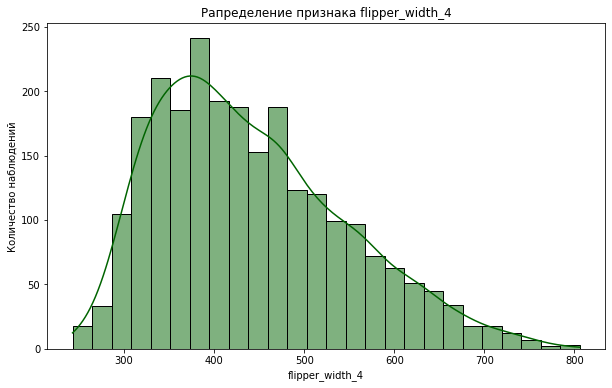

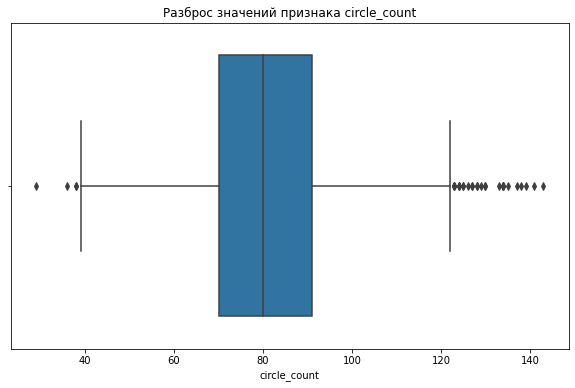

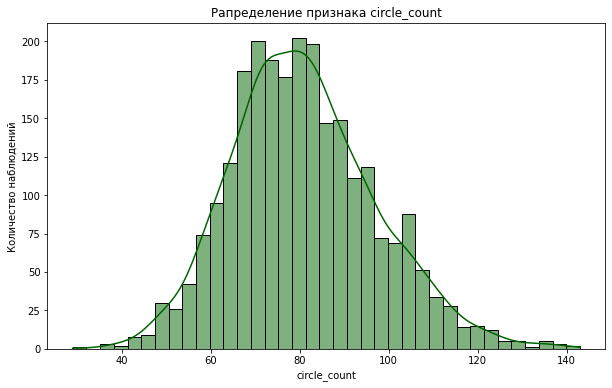

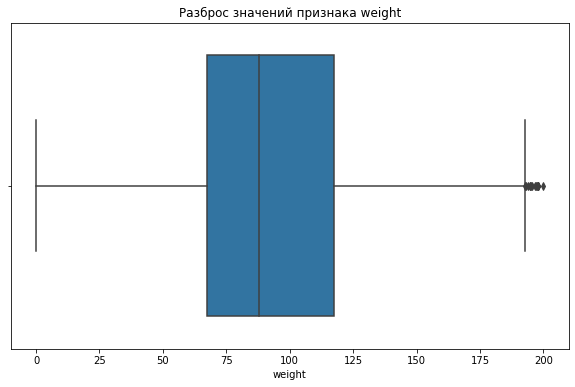

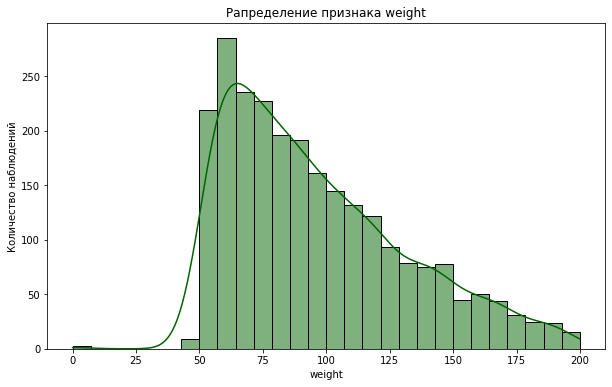

In [13]:
# Боксплот для каждого оставшегося признака
for column in chelonia_mydas_df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=chelonia_mydas_df[column])
    plt.title(f'Разброс значений признака {column}')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=chelonia_mydas_df, x=column,
                color='darkgreen', kde=True)
    plt.ylabel('Количество наблюдений')
    plt.title(f'Рапределение признака {column}')
    plt.show()

    Знаем, что в данных могут встречаться ошибки - значения которые были умножены на 10, хорошо эти ошибки видно в столбцах shell_length и shell_width. чтобы их устранить, разделим значения-выбросы которые больше 6000 мм на 10. Остальные выбросы не выглядят критическими и являются частью данных - с ними ничего не делаем.

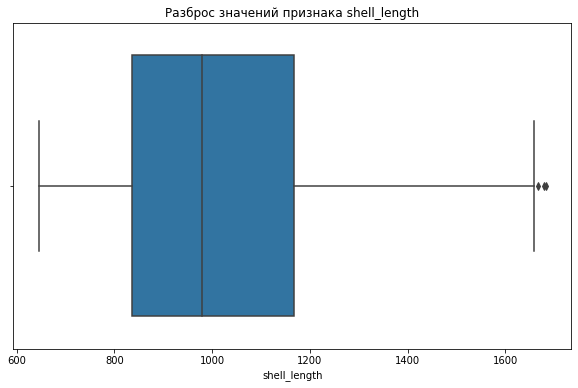

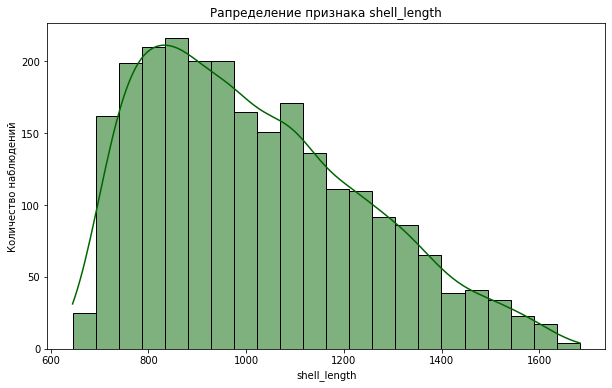

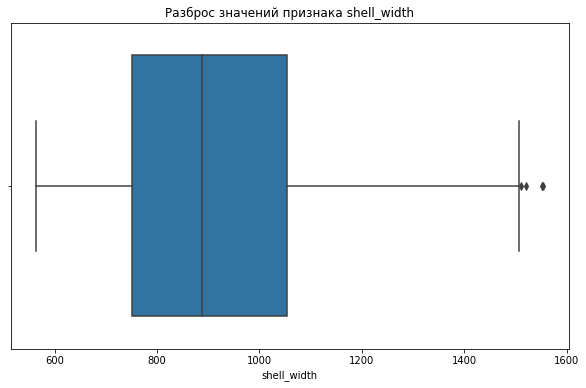

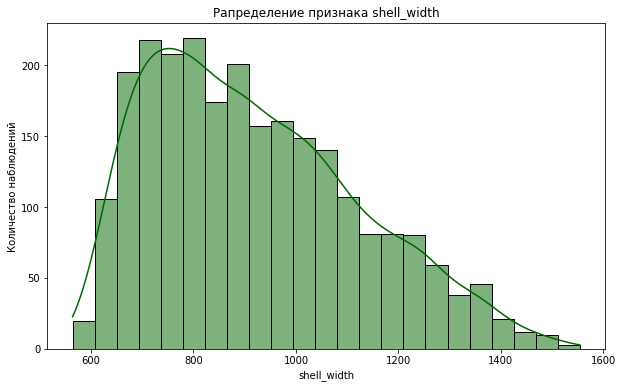

In [14]:
def divide_by_ten(row, max_val=5999):
    """ Делит на 10 значения больше чем max_val """
    if row > max_val:
        return int(row / 10)
    else:
        return row
    
chelonia_mydas_df['shell_length'] = chelonia_mydas_df['shell_length'].apply(divide_by_ten)
chelonia_mydas_df['shell_width'] = chelonia_mydas_df['shell_width'].apply(divide_by_ten)


# боксплот и график распределения после исправления ошибок в столбцах
for i in ['shell_length', 'shell_width']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=chelonia_mydas_df[i])
    plt.title(f'Разброс значений признака {i}')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=chelonia_mydas_df, x=i,
                color='darkgreen', kde=True)
    plt.ylabel('Количество наблюдений')
    plt.title(f'Рапределение признака {i}')
    plt.show()

Распределение признака 'circle_count' очень похоже на нормальное, а т.к. количество колец на панцире зависит от возраста черепахи, можно предположить, что в наблюдениях представлены данные о черепахах различных возрастов. Распределения всех остальных признаков имеют правосторонюю ассиметрию, что свидетельствует о наличии больших значений признаков в данных.

interval columns not set, guessing: ['shell_length', 'shell_width', 'head_length', 'head_width', 'flipper_length_1', 'flipper_width_1', 'flipper_length_2', 'flipper_width_2', 'flipper_length_3', 'flipper_width_3', 'flipper_length_4', 'flipper_width_4', 'circle_count', 'weight']


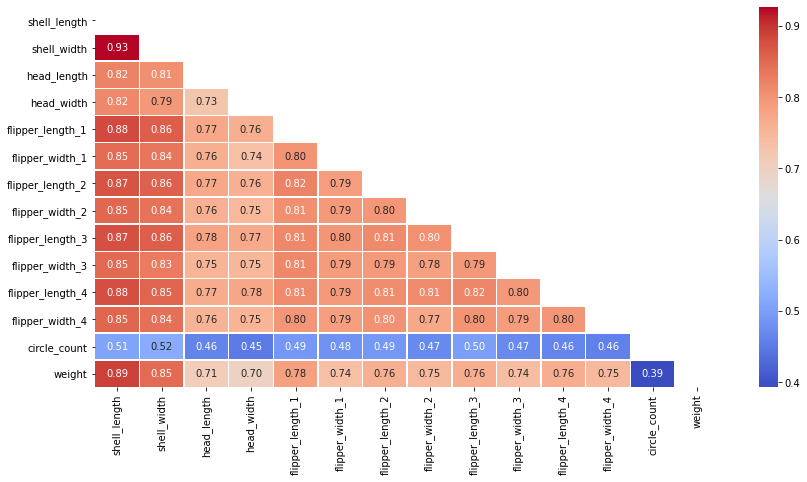

In [15]:
corr_data = chelonia_mydas_df.phik_matrix()

plt.figure(figsize=(14, 7))
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(data=corr_data, annot=True,
            fmt='.2f', linewidths=0.5,
            cmap='coolwarm', mask=mask,)
plt.show()

В данных явно видна мультиколлинеарность между признаками. Особено хорошо выражено влияние характеристик панциря (shell_length и shell_width) на массу черепахи. Далее, для решения проблемы мультиколлинеарности будет использоваться регуляризация.

## Предобработка данных

1. Разделите данные на выборки: обучающую (60%), валидационную (20%) и тестовую (20%). В реальных проектах стараются писать код предобработки так, чтобы предотвратить утечку данных. Это проще сделать, если сразу поделить данные.
2. Обработайте пропуски. При необходимости заполните их средними (медианными) значениями. Рассчитайте заполнитель только по обучающей выборке: это ещё одно правило для предотвращения утечки.
3. Напишите функцию для стандартизации признаков. Расчёт параметров масштабирования делайте только по обучающей выборке, чтобы не дать утечке ни малейшего шанса.
4. Напишите функцию для нормализации признаков.
5. Подготовьте несколько датасетов из трёх выборок каждый для дальнейшего обучения моделей с разным способом масштабирования: без масштабирования, с нормализацией, со стандартизацией.

In [16]:
X = chelonia_mydas_df.drop(columns='weight')
y = chelonia_mydas_df['weight']

X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                 test_size=0.2, shuffle=True,
                                                 random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                 test_size=0.25, shuffle=True,
                                                 random_state=42)

# проверка
print(f"X_train: {len(X_train) / (len(X_train) + len(X_val) + len(X_test))*100:.1f}%")
print(f"X_val: {len(X_val) / (len(X_train) + len(X_val) + len(X_test))*100:.1f}%")
print(f"X_test: {len(X_test) / (len(X_train) + len(X_val) + len(X_test))*100:.1f}%")

X_train: 60.0%
X_val: 20.0%
X_test: 20.0%


In [17]:
# Сравнение медианных значений и средних
for column in chelonia_mydas_df.columns:
    print(f"Столбец: {column}")
    print(f" Среднее: {chelonia_mydas_df[column].mean():.1f}")
    print(f" Медиана: {chelonia_mydas_df[column].median():.1f}")
    print()

Столбец: shell_length
 Среднее: 1018.4
 Медиана: 979.0

Столбец: shell_width
 Среднее: 919.0
 Медиана: 887.0

Столбец: head_length
 Среднее: 169.7
 Медиана: 163.0

Столбец: head_width
 Среднее: 183.3
 Медиана: 176.0

Столбец: flipper_length_1
 Среднее: 612.0
 Медиана: 587.0

Столбец: flipper_width_1
 Среднее: 549.4
 Медиана: 527.0

Столбец: flipper_length_2
 Среднее: 611.9
 Медиана: 591.0

Столбец: flipper_width_2
 Среднее: 550.3
 Медиана: 533.0

Столбец: flipper_length_3
 Среднее: 487.3
 Медиана: 473.0

Столбец: flipper_width_3
 Среднее: 440.7
 Медиана: 425.0

Столбец: flipper_length_4
 Среднее: 489.2
 Медиана: 473.0

Столбец: flipper_width_4
 Среднее: 441.0
 Медиана: 423.0

Столбец: circle_count
 Среднее: 80.9
 Медиана: 80.0

Столбец: weight
 Среднее: 96.1
 Медиана: 87.9



In [18]:
# Заполнение пропусков медианой
for column in X_train.columns:
    train_median = X_train[column].median()
    
    X_train[column] = X_train[column].fillna(train_median)
    X_val[column] = X_val[column].fillna(train_median)
    X_test[column] = X_test[column].fillna(train_median)
    
# Проврека что нет NaN
print(X_train.info())
print()
print(X_val.info())
print()
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 798 to 5813
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   shell_length      1491 non-null   float64
 1   shell_width       1491 non-null   int64  
 2   head_length       1491 non-null   float64
 3   head_width        1491 non-null   float64
 4   flipper_length_1  1491 non-null   int64  
 5   flipper_width_1   1491 non-null   int64  
 6   flipper_length_2  1491 non-null   int64  
 7   flipper_width_2   1491 non-null   int64  
 8   flipper_length_3  1491 non-null   float64
 9   flipper_width_3   1491 non-null   float64
 10  flipper_length_4  1491 non-null   float64
 11  flipper_width_4   1491 non-null   float64
 12  circle_count      1491 non-null   int64  
dtypes: float64(7), int64(6)
memory usage: 163.1 KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 2265 to 3720
Data columns (total 13 columns):
 #   Column        

In [19]:
def standardize(df:pd.DataFrame, train_means = X_train.mean(), train_std = X_train.std()):
    """ Стандартизация признаков """ 
    result_df = pd.DataFrame()
    for column in df.columns:
        result_df[column] = (df[column] - train_means[column]) / train_std[column]
    return result_df

def scaling(df:pd.DataFrame, min_val = X_train.min(), max_val = X_train.max()):
    """ Масштабирование признаков """
    result_df = pd.DataFrame()
    for column in df.columns:
        # Используем имя колонки как индекс для min_val/max_val
        result_df[column] = (df[column] - min_val[column]) / (max_val[column] - min_val[column])
    return result_df

In [20]:
# Создание масштабированных выборок
X_train_standarized = standardize(X_train)
X_val_standarized = standardize(X_val)

X_train_scaled = scaling(X_train)
X_val_scaled = scaling(X_val)

## Обучение моделей

1. Постройте базовую модель (дамми), с которой будете сравнивать все остальные. Если они будут хуже базовой по качеству, это будет означать, что при обучении что-то пошло не так. Пример дамми: модель, которая всегда предсказывает среднее значение целевой переменной из обучающей выборки.
2. Обучите несколько архитектур линейных моделей. Они могут различаться по ряду черт: набором отобранных признаков, масштабом признаков, установленными гиперпараметрами, функциями потерь. Попробуйте обучить следующие модели:
   - `LinearRegression`;
   - `Lasso` (L1-регуляризация);
   - `Ridge` (L2-регуляризация);
   - `SGDRegressor`.
   
   Обязательно попробуйте модели с разными значениями гиперпараметра `loss`.
- **Бонусное задание.** Подумайте, можно ли улучшить модели за счёт создания новых признаков: например, умножив длину ласт на ширину. Проверьте, усилится ли корреляция нового признака с целевой переменной, возрастёт ли благодаря ему качество модели.
3. Сформируйте итоговую таблицу с результатами моделей. Это удобно сделать в виде датафрейма pandas. Включите в таблицу следующие столбцы:
   - Название модели.
   - Название датасета — оно должно указывать на то, какой способ масштабирования использовался при подготовке данных.
   - Метрики качества, рассчитанные на валидационной выборке. Основная метрика — MAE, дополнительные — MSE, R², MAPE и прочие.

In [21]:
def calculate_mape(actual, predicted):
    """ Расчет MAPE """
    actual, predicted = np.array(actual), np.array(predicted)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100


def get_metrics(y, y_pred):
    """ Вывод метрик """
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mape = calculate_mape(y, y_pred)
    return (round(mse, 2), round(mae, 2), round(mape, 2), round(r2, 4))

In [22]:
class DummyModel:
    def __init__(self):
        self.mean_target = None

    def fit(self, X_train, y_train):
        self.mean_target = y_train.mean()
        return self

    def predict(self, X_test):
        return np.full(shape=len(X_test), fill_value=self.mean_target)

In [23]:
def linear_regression(X_train, y_train, X_val, y_val, info=True):
    """ Построение модели линейной регрессии """
    
    # Линейная регрессия
    
    # Модель
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred_val_linear = linear_model.predict(X_val)
    
    mse, mae, mape, r2 = get_metrics(y_val, y_pred_val_linear)
    
    if info:
        # Вывод результатов
        print(f"Коэффициенты признаков:\n{linear_model.coef_}")
        print(f'Свободный признак: {linear_model.intercept_:.4f}')
        print(f"Linear Regression MAE: {mae:.2f}\n")
    
    return {'MAE':mae, 'MSE':mse, 'MAPE':mape, "R2":r2}

In [24]:
def regularization_lasso(X_train, y_train, X_val, y_val, info=True):
    """ Модель с регуляризацией Lasso """
    
    alphas = [0.001, 0.01, 0.1, 1, 10, 50, 100]
    
    # L1 (Lasso)
    best_alpha_lasso = None
    best_mae_lasso = float('inf')
    lasso_final = None
    model_mse = None
    model_mape = None
    model_r2 = None
    
    # Модель Lasso
    for alpha in alphas:
        lasso_model = Lasso(alpha=alpha)
        lasso_model.fit(X_train, y_train)
        y_pred_val_lasso = lasso_model.predict(X_val)
        mse_lasso, mae_lasso, mape_lasso, r2_lasso = get_metrics(y_val, y_pred_val_lasso)
        
        if mae_lasso < best_mae_lasso:
            best_mae_lasso = mae_lasso
            best_alpha_lasso = alpha
            lasso_final = lasso_model
            model_mse = mse_lasso
            model_mape = mape_lasso
            model_r2 = r2_lasso
        
        if info:
            print(f"L1 - MAE при alpha {alpha}: {mae_lasso:.2f}")
    if info:     
        print(f"Лучшая модель Lasso достигается при alpha: {best_alpha_lasso}, MAE {best_mae_lasso}\n\n")
    
    
    return {'MAE':best_mae_lasso, 'MSE':model_mse, 'MAPE':model_mape, "R2":model_r2}

In [25]:
def regularization_ridge(X_train, y_train, X_val, y_val, info=True):
    """ Модель с регуляризацией Ridge """
    
    alphas = [0.001, 0.01, 0.1, 1, 10, 50, 100]
    
    # L2 (Ridge)
    best_alpha_ridge = None
    best_mae_ridge = float('inf')
    ridge_final = None
    model_mse = None
    model_mape = None
    model_r2 = None
    
    # Модель Ridge
    for alpha in alphas:
        ridge_model = Ridge(alpha=alpha)
        ridge_model.fit(X_train, y_train)
        y_pred_val_ridge = ridge_model.predict(X_val)
        mse_ridge, mae_ridge, mape_ridge, r2_ridge = get_metrics(y_val, y_pred_val_ridge)
        
        if mae_ridge < best_mae_ridge:
            best_mae_ridge = mae_ridge
            best_alpha_ridge = alpha
            ridge_final = ridge_model
            model_mse = mse_ridge
            model_mape = mape_ridge
            model_r2 = r2_ridge
            
        if info:
            print(f"L2 - MAE при alpha {alpha}: {mae_ridge:.2f}")
    if info:      
        print(f"Лучшая модель Ridge достигается при alpha: {best_alpha_ridge}, MAE {best_mae_ridge}\n\n")
    
    return {'MAE':best_mae_ridge, 'MSE':model_mse, 'MAPE':model_mape, "R2":model_r2}

In [26]:
def sgd_regressor(X_train, y_train, X_val, y_val, info=True):
    """ Модель  SGDRegressor """
    
    losses = ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
    learning_rates = ['constant', 'invscaling', 'adaptive']
    etas = [0.01, 0.1, 1]
    max_iters = [1000, 5000, 10000]
    
    best_loss = None
    best_learning_rate = None
    best_eta = None
    best_max_iter = None
    best_mae = float('inf')
    sdg_final = None
    model_mse = None
    model_mape = None
    model_r2 = None
    
    for loss in losses: 
        for learning_rate in learning_rates:
            for eta in etas:
                for max_iter in max_iters:

                    model_sgd = SGDRegressor(
                        loss=loss,
                        learning_rate=learning_rate,
                        eta0=eta,
                        max_iter=max_iter,
                        tol=1e-3,
                        random_state=42
                    )

                    model_sgd.fit(X_train, y_train)
                    y_pred_sgd = model_sgd.predict(X_val)
                    mse, mae, mape, r2 = get_metrics(y_val, y_pred_sgd)

                    if mae < best_mae:
                        best_loss = loss
                        best_learning_rate = learning_rate
                        best_eta = eta
                        best_max_iter = max_iter
                        best_mae = mae
                        sdg_final = model_sgd
                        model_mse = mse
                        model_mape = mape
                        model_r2 = r2
    
    if info:
        print("Аналитические коэффициенты:", model_sgd.coef_)
        print(f"Лучший MAE для SDG Regressor: {best_mae}")
        print("Параметры при лучшем MAE:")
        print(f"loss: {best_loss}")
        print(f"learning_rate: {best_learning_rate}")
        print(f"eta: {best_eta}")
        print(f"max_iter: {best_max_iter}")
        print()
    
    return {'MAE':best_mae, 'MSE':model_mse, 'MAPE':model_mape, "R2":model_r2, 'model':sdg_final}

In [27]:
# Запускаем все модели и собираем результаты в общую таблицу

# Димми модель
dymmy_test = DummyModel()
dymmy_test.fit(X_train, y_train)
dymmy_pred = dymmy_test.predict(X_val)
mse_dummy, mae_dymmy, mape_dymmy, r2_dymmy = get_metrics(y_val, dymmy_pred)

results = [{'Model_Type':'DummyModel',
            'Data_Type':'_',
            'Full_Model_Name': '_',
            'R2':r2_dymmy, 
            'MAE': mae_dymmy, 
            'MSE':mse_dummy, 
            'MAPE':mape_dymmy}]

# Все остальные модели
parameters = ((X_train, y_train, X_val, y_val, False),
     (X_train_standarized, y_train, X_val_standarized, y_val, False),
     (X_train_scaled, y_train, X_val_scaled, y_val, False))

model_functions = {
    'Linear_Regression': linear_regression,
    'Lasso': regularization_lasso,
    'Ridge': regularization_ridge,
    'SGDRegressor': sgd_regressor
}

models = [
    ['Linear_Regression', 'Linear_Regression_стандартизация', 'LinearRegression_мин_макс_масштабирование'],
    ['Lasso', 'Lasso_стандартизация', 'Lasso_мин_макс_масштабирование'],
    ['Ridge', 'Ridge_стандартизация', 'Ridge_мин_макс_масштабирование'],
    ['SGDRegressor', 'SGDRegressor_стандартизация', 'SGDRegressor_мин_макс_масштабирование']
]



data_types = ['original', 'standardized', 'scaled']

for model_group in models:
    model_base_name = model_group[0].split('_')[0] if '_' in model_group[0] else model_group[0]
    
    for i, (model_name, data_tuple) in enumerate(zip(model_group, parameters)):
        train_func = model_functions.get(model_base_name)
        
        if train_func:
            metrics = train_func(*data_tuple)
            results.append({
                'Model_Type': model_base_name,
                'Data_Type': data_types[i],
                'Full_Model_Name': model_name,
                'R2': metrics['R2'],
                'MAE': metrics['MAE'],
                'MSE': metrics['MSE'],
                'MAPE': metrics['MAPE']
            })

models_df = pd.DataFrame(results)
models_df = models_df.sort_values(by='MAE', ascending=True)
models_df

,Model_Type,Data_Type,Full_Model_Name,R2,MAE,MSE,MAPE
8,SGDRegressor,standardized,SGDRegressor_стандартизация,0.9734,3.71,33.20,3.93
9,SGDRegressor,scaled,SGDRegressor_мин_макс_масштабирование,0.9735,3.72,33.15,3.92
6,Ridge,scaled,Ridge_мин_макс_масштабирование,0.9742,3.77,32.20,4.11
1,Lasso,original,Lasso,0.9742,3.78,32.24,4.13
2,Lasso,standardized,Lasso_стандартизация,0.9742,3.78,32.25,4.13
3,Lasso,scaled,Lasso_мин_макс_масштабирование,0.9742,3.78,32.25,4.13
4,Ridge,original,Ridge,0.9742,3.78,32.24,4.13
5,Ridge,standardized,Ridge_стандартизация,0.9742,3.78,32.24,4.13
7,SGDRegressor,original,SGDRegressor,0.8754,8.36,155.75,7.39
0,DummyModel,_,_,-0.0034,29.58,1253.93,34.56


## Сравнение моделей на валидационной выборке

1. Сравните построенные модели по метрикам на валидационной выборке. Удалось ли существенно улучшить результат базовой модели?
2. Выберите лучшую модель по основной метрике на валидационной выборке. Не заглядывайте в метрики на тестовой выборке раньше времени. Тестовая выборка не используется для обучения моделей, подбора гиперпараметров и сравнения моделей с разными значениями.
3. Напишите выводы о том, какая из моделей обладает лучшим качеством. Именно её одну далее нужно проверить на тестовой выборке для итоговой оценки.

Ответы на вопросы:
  - По основной метрике (MAE), все модели, кроме SGDRegressor без масштабирования признаков и DummyModel показывают хорошие результаты, удовлетворяющие условим заказчика.
  - Наилучшей моделью по MAE является модель линейной регрессии с использованием стохастического градиентного спуска. По основной метрике эта модель показала результат в 8 раз лучше, чем базовая.

## Проверка лучшей модели на тестовой выборке

1. Проверьте метрики лучшей модели на тестовой выборке.
2. Узнайте, есть ли признаки переобучения лучшей модели.
3. Определите, соответствует ли модель требованиям заказчика. Объясните, можно ли её рекомендовать к внедрению.

In [28]:
print("SGD Regressor со стандартизацией на тестовой выборке")
X_test_standarized = standardize(X_test)
t = sgd_regressor(X_train_standarized, y_train, X_test_standarized, y_test, info=False)
print('Метрики на тестовой выборке:')
print(f'MAE: {t["MAE"]}')
print(f'MSE: {t["MSE"]}')
print(f'MAPE: {t["MAPE"]}')
print(f'R2: {t["R2"]}')

SGD Regressor со стандартизацией на тестовой выборке
Метрики на тестовой выборке:
MAE: 3.84
MSE: 27.93
MAPE: 4.08
R2: 0.9775


Выводы:
  - Модель SGDRegressor со стандартизацией на тестовой выборке показывает примерно такие же результаты, как и на валидационной. Разница в основной метрике MAE составляет 0.13.
  - Признаков переобучения модели нет.
  - Модель соответствует трубованиям заказчика.

## Оценка важности признаков

1. Оцените важность признаков по абсолютным значениям весов лучшей модели.
2. Напишите, какие признаки стали для модели более важными. Объясните, согласны ли вы с таким результатом?

Коэффициенты признаков
shell_length : 11.95
shell_width : 6.48
head_length : 1.61
head_width : 1.04
flipper_length_1 : 2.61
flipper_width_1 : 1.78
flipper_length_2 : 2.74
flipper_width_2 : 1.69
flipper_length_3 : 1.45
flipper_width_3 : 1.10
flipper_length_4 : 1.29
flipper_width_4 : 1.43
circle_count : 0.50
Свободный коэффициент: 96.48



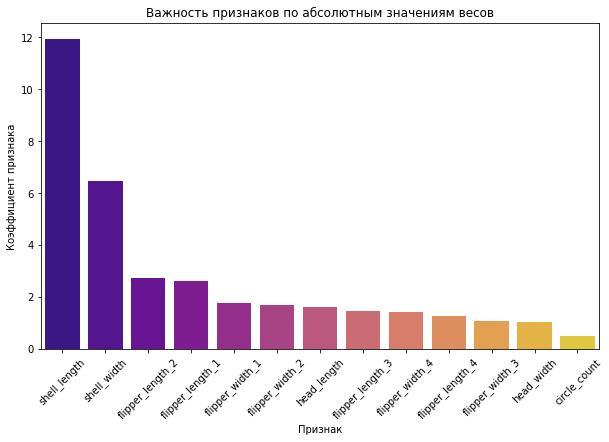

In [29]:
sgd_model = sgd_regressor(X_train_standarized, y_train, X_test_standarized, y_test, info=False)['model']
coeffs = sgd_model.coef_
intercept = sgd_model.intercept_

print('Коэффициенты признаков')
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]} : {coeffs[i]:.2f}")
print(f"Свободный коэффициент: {float(intercept):.2f}\n")


# барплот
coeffs_df = pd.DataFrame({
    'feature' : X_train.columns,
    'coeffs' : coeffs
})

coeffs_df = coeffs_df.sort_values(by='coeffs', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=coeffs_df['feature'], y=coeffs_df['coeffs'],
           palette='plasma')

plt.title('Важность признаков по абсолютным значениям весов')
plt.xlabel('Признак')
plt.ylabel('Коэффициент признака')
plt.xticks(rotation=45)
plt.show()

  - Наиболее важными признаками являются показатели длины и ширины панциря, что логично, т.к. это основные показатели которые отображают размер черепахи, а для массы он является более важным чем размер конечностей.
  - Размеры кончностей (лапы по отдельности и голова) имеют примерно равную важность для модели
  - Наименее важным признаком для модели является количество колец роста на панцире черепахи. Скорее всего это происходит потому что количество колец зависит от возраста, а возраст влияет на размеры черепахи, иными словами, количество колец частично оказывает влияние на размеры черепахи, которые уже выделены в модели как отдельные признаки.

## Функция для прогнозирования веса черепахи

* Напишите на Python функцию, которая будет прогнозировать массу черепахи по заданным параметрам с учётом коэффициентов лучшей модели (свойство `coef_`) и смещения (свойство `intercept_`).
* Если вы столкнётесь с трудностями при написании функции, то представьте, что обращаетесь к старшему коллеге с просьбой помочь, и составьте задание для её написания. Подробно опишите логику, по которой рассчитывается масса черепахи, и укажите, как именно должны происходить расчёты.

In [30]:
def pred_by_formula(shell_length, shell_width, head_length,
                   head_width, flipper_length_1, flipper_width_1,
                   flipper_length_2, flipper_width_2, flipper_length_3,
                   flipper_width_3, flipper_length_4, flipper_width_4,
                   circle_count):
    """
    Предсказание веса черепахи по коэффициентам
    Используется коэффициенты модели SGD Regressor со стандартизированными признаками
    """
    
    params = [shell_length, shell_width, head_length,
           head_width, flipper_length_1, flipper_width_1,
           flipper_length_2, flipper_width_2, flipper_length_3,
           flipper_width_3, flipper_length_4, flipper_width_4,
           circle_count]
    
    # Стандартизация признаков
    df = pd.DataFrame([params], columns=X_train.columns)     
    df_standardized = standardize(df)
    params_standardized = df_standardized.values.tolist()[0]
    
    # Расчет y
    res = float(intercept)
    for i in range(len(params_standardized)):
        res += params_standardized[i] * coeffs[i]
    
    return round(res, 4)

In [31]:
X_train.sample(5)

,shell_length,shell_width,head_length,head_width,flipper_length_1,flipper_width_1,flipper_length_2,flipper_width_2,flipper_length_3,flipper_width_3,flipper_length_4,flipper_width_4,circle_count
1292,696.0,630,119.0,107.0,449,403,379,393,330.0,291.0,336.0,292.0,79
7509,791.0,685,117.0,109.0,442,331,478,451,403.0,340.0,414.0,349.0,48
4830,1098.0,1015,228.0,156.0,740,614,613,573,545.0,445.0,521.0,494.0,84
5287,983.0,935,168.0,182.0,635,657,475,480,535.0,431.0,466.0,422.0,95
20,703.0,606,164.0,178.0,355,382,411,340,302.0,355.0,314.0,283.0,62


In [32]:
ind = 7701 # индекс строки из X_train который хотим проверить через функцию pred_by_formula 

try:
    vals = X_train.loc[ind]
    print(f"Предсказанное значение: {pred_by_formula(*vals.values)}")
    print(f"Реальное значение: {y_train.loc[ind]}")
except:
    print(f"Индекс {ind} не найден в X_train")

Предсказанное значение: 126.7398
Реальное значение: 126.087


In [33]:
# Проверка что все работает на тестовой выборке

pred = []

for _, row in X_test.iterrows():
    pred.append(pred_by_formula(
        row['shell_length'],
        row['shell_width'],
        row['head_length'],
        row['head_width'],
        row['flipper_length_1'],
        row['flipper_width_1'],
        row['flipper_length_2'],
        row['flipper_width_2'],
        row['flipper_length_3'],
        row['flipper_width_3'],
        row['flipper_length_4'],
        row['flipper_width_4'],
        row['circle_count']
    ))
    

mse, mae, mape, r2 = get_metrics(y_test, pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MSE: 27.93
MAE: 3.84
MAPE: 4.08
R2: 0.9775


## Общие выводы и рекомендации по дальнейшей работе

Напишите общие выводы и рекомендации по дальнейшей работе. Ответьте на вопросы:
  - Какие модели изучены?
  - Какие результаты получены?
  - Рекомендуется ли итоговая модель к внедрению?
  - Какая архитектура и способ обработки признаков показали себя лучше всего? Какие у них показатели метрик?
  - Какие признаки наиболее важны для модели?
  - Есть ли перспективы у обучения этой или других моделей для предсказания массы других видов черепах?
  - При наличии добавьте сюда свои предложения по дальнейшему развитию проекта.

  - Были изучены модели:
    - Линейная регрессия
    - Линейная регрессия с L1-регуляризацией
    - Линейная регрессия с L2-регуляризацией
    - Линейная регрессия  с использованием стохастического градиентного спуска
  - Все модели, кроме SGDRegressor без масштабирования признаков достигают нужного результата
  - Модель SGDRegressor со стандартизацией может быть рекомендована к внедрению
  - Наиболее важными признаками для прогнозирования массы черепахи являются длина и ширина панциря 
  - Скорее всего данная модель может использоваться для прогнозирования массы черепах других видов при условии обучения на данных соответствующего вида